# 모델 저장

- 학습한 모델을 저장장치에 파일로 저장하고 나중에 불러와 사용(추가 학습, 예측 서비스) 할 수 있도록 한다. 
- 파이토치는 모델의 파라미터만 저장하는 방법과 모델 구조와 파라미터 모두를 저장하는 두가지 방식을 제공한다.
- 저장 함수
    - `torch.save(저장할 객체, 저장경로)`
- 보통 저장파일의 확장자는 `pt`나 `pth` 를 지정한다.

## 모델 전체 저장하기 및 불러오기

- 저장하기
    - `torch.save(model, 저장경로)`
- 불러오기
    - `load_model = torch.load(저장경로)`
- 저장시 **pickle**을 이용해 직렬화하기 때문에 불어오는 실행환경에도 모델을 저장할 때 사용한 클래스가 있어야 한다.



## 모델의 파라미터만 저장
- 모델을 구성하는 파라미터만 저장한다.
- 모델의 구조는 저장하지 않기 때문에 불러올 때 **모델을 먼저 생성하고 생성한 모델에 불러온 파라미터를 덮어씌운다.**
- 모델의 파라미터는 **state_dict** 형식으로 저장한다.

### state_dict
- 모델의 파라미터 Tensor들을 레이어 단위별로 나누어 저장한 Ordered Dictionary (OrderedDict)
- `모델객체.state_dict()` 메소드를 이용해 조회한다.
- 모델의 state_dict을 조회 후 저장한다.
    - `torch.save(model.state_dict(), "저장경로")`
- 생성된 모델에 읽어온 state_dict를 덮어씌운다.
    - `new_model.load_state_dict(torch.load("state_dict저장경로"))`


In [1]:
import torch
import torch.nn as nn

class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lr = nn.Linear(28*28, 64)
        self.lr2 = nn.Linear(64, 32)
        self.lr3 = nn.Linear(32, 10)
    
    def forward(self, X):
        X = torch.flatten(X, start_dim=1)
        X = nn.ReLU()(self.lr(X))
        X = nn.ReLU()(self.lr2(X))
        X = (self.lr3(X))
        return X

In [5]:
# state_dict 조회
sample_model = Network()
sample_model

Network(
  (lr): Linear(in_features=784, out_features=64, bias=True)
  (lr2): Linear(in_features=64, out_features=32, bias=True)
  (lr3): Linear(in_features=32, out_features=10, bias=True)
)

In [9]:
sd = sample_model.state_dict()
sd.keys()

odict_keys(['lr.weight', 'lr.bias', 'lr2.weight', 'lr2.bias', 'lr3.weight', 'lr3.bias'])

In [10]:
sd['lr.weight'].shape

torch.Size([64, 784])

In [11]:
sample_model.parameters()

<generator object Module.parameters at 0x7f29dacfedc0>

In [4]:
save_path  = r'./models/{model_target}/{file_name}'
model_file_name = r'{model_name}_{YYMMDDhhmm}.pth'

def get_timestamp():
    import datetime
    return datetime.datetime.now().strftime('%Y%m%d%H%M')

def get_path(model_name, model_target):
    file_name = model_file_name.format(model_name=model_name, YYMMDDhhmm=get_timestamp())
    return save_path.format(model_target=model_target, file_name=file_name)

# Checkpoint를 저장 및 불러오기
- 학습이 끝나지 않은 모델을 저장 후 나중에 이어서 학습시킬 경우에는 모델의 구조, 파라미터 뿐만 아니라 optimizer, loss 함수등 학습에 필요한 객체들을 저장해야 한다.
- Dictionary에 필요한 요소들을 key-value 쌍으로 저장후 `torch.save()`를 이용해 저장한다.
```python
# 저장
torch.save({
    'epoch':epoch,                                  # 현재 학습 epoch
    'model_state_dict':model.state_dict(),          # 모델 저장
    'optimizer_state_dict':optimizer.state_dict(),  # 옵티마이저 저장
    'loss':train_loss                               # 현재 학습 loss
}, "저장경로")

# 불러오기
model = MyModel()                           # 모델 생성
optimizer = optim.Adam(model.parameter())   # 옵티마이저 생성

checkpoint = torch.load("저장경로")                             # 저장된 모델 불러오기
model.load_state_dict(checkpoint['model_state_dict'])           # 모델 불러오기
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])   # 옵티마이저 불러오기
epoch = checkpoint['epoch']                                     # 현재 학습 epoch
loss = checkpoint['loss']                                       # 현재 학습 loss

#### 이어학습 -> train 모드로 변경
model.train()
#### 추론     -> eval 모드로 변경
model.eval()
```

In [ ]:
save_path  = r'./models/{model_target}/{file_name}'
model_file_name = r'{model_name}_{times}.pth'

# 문제 유형별 MLP 네트워크
- MLP(Multi Layer Perceptron)
    - Fully Connected Layer로 구성된 네트워크

In [2]:
import datetime
import time
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset

import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
CPU = 'cpu'

DEVICE, CPU

('cuda', 'cpu')

# Regression(회귀)

## Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

## Dataset, DataLoader 생성

In [3]:
boston = pd.read_csv(r'./data/boston_hosing.csv')
boston.shape

X_boston = boston.drop(columns='MEDV').values
y_boston = boston['MEDV'].values.reshape(-1,1)
X_boston.shape, y_boston.shape

((506, 13), (506, 1))

In [4]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X_boston, y_boston, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404, 1), (102, 1))

In [13]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# y를 tensor로 변환
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [30]:
# Dataset, DataLoader 생성

# Dataset
boston_train_dataset = TensorDataset(X_train_scaled, y_train_tensor)
boston_test_dataset = TensorDataset(X_test_scaled, y_test_tensor)

print(len(boston_train_dataset), len(boston_test_dataset))
print(boston_train_dataset[0])


# DataLoader
boston_train_loader = DataLoader(boston_train_dataset,
                                batch_size=202, 
                                shuffle=True,
                                drop_last=True
                                )

boston_test_loader = DataLoader(boston_test_dataset,
                                batch_size=len(boston_test_dataset),
                                )

# epoch당 step 수
print(len(boston_train_loader), len(boston_test_loader))

404 102
(tensor([-0.3726, -0.4996, -0.7049,  3.6645, -0.4249,  0.9357,  0.6937, -0.4372,
        -0.1622, -0.5617, -0.4846,  0.3717, -0.4110]), tensor([26.7000]))
2 1


## 모델 정의

In [31]:
class BostonModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # 입력 layer -> in_features: input data의 feature 수
        self.input_lr = nn.Linear(13, 32)
        # hidden layer -> in_features: 이전 layer의 output feature 수
        self.hidden_lr = nn.Linear(32, 16)
        # 출력 layer -> in_features: 이전 layer의 output feature 수
        #               out_features: output data의 feature 수
        # regression이므로 output_feature 수는 1
        self.output_lr = nn.Linear(16, 1)
        
        
    def forward(self, X):
        # input layer
        X_out = self.input_lr(X)      # 입력 layer에 input data를 넣어 output을 계산
        X_in = nn.ReLU()(X_out)       # 비선형 함수를 통과시켜줌
        # hidden layer
        X_out = self.hidden_lr(X_in)  # hidden layer에 input data를 넣어 output을 계산
        X_in = nn.ReLU()(X_out)       # 비선형 함수를 통과시켜줌
        # output layer - output layer는 activation function을 사용하지 않음
        #   예외: 출력결과가 특정 활성함수의 출력과 매칭되어야 하는 경우
        #       output: 0~1 -> sigmoid, logistic
        #       output: -1~1 -> tanh(hyperbolic tangent)
        X_out = self.output_lr(X_in)  # 출력 layer에 input data를 넣어 output을 계산
        
        return X_out

In [32]:
boston_model = BostonModel()
torchinfo.summary(boston_model, input_size=(202, 13))

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [202, 1]                  --
├─Linear: 1-1                            [202, 32]                 448
├─Linear: 1-2                            [202, 16]                 528
├─Linear: 1-3                            [202, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [41]:
N_RPOCH = 1000
LEARNING_RATE = 0.001
# 결과 저장용 list
train_loss_list = []
val_loss_list = []

In [42]:
# 모델, loss function, optimizer 정의
# 모델 정의
boston_model = BostonModel()
# 모델 -> GPU로 이동
boston_model = boston_model.to(DEVICE)
# loss function
loss_func = nn.MSELoss()
# optimizer
# RMSprop : Adam보다 더 빠르게 수렴하는 경향이 있음
optimizer = torch.optim.RMSprop(boston_model.parameters(), lr=LEARNING_RATE)

In [43]:
# 학습
# 단계 - 학습/검증
for epoch in range(N_RPOCH):
    ###################################
    # 학습 단계
    ###################################
    # 학습 모드로 변경
    boston_model.train()
    # loss 계산을 위한 변수 초기화
    train_loss = 0.0
    
    for X, y in boston_train_loader:
        # DEVICE로 이동
        X, y = X.to(DEVICE), y.to(DEVICE)
        # 1. 모델 추정
        y_pred = boston_model(X)    # forward propagation(순전파)
        # 2. loss 계산
        loss = loss_func(y_pred, y) # fn(추정값, 정답)
        # 3. gradient 계산 -> 파라미터 업데이트
            ## 3-1. gradient를 0으로 초기화
        optimizer.zero_grad()
            ## 3-2. back propagation(역전파)를 통해 gradient 계산 -> grad속성에 저장
        loss.backward()
            ## 3-3. 파라미터 업데이트 -> 1 step
        optimizer.step()
        # 4. 현재 batch의 loss를 train_loss에 가산
        train_loss += loss.item()
    # batch에 대한 loss 평균 계산
    train_loss /= len(boston_train_loader)
    ######### epoch 학습 종료 #########
    
    ###################################
    # 검증 단계
    ###################################
    # 검증 모드로 변경
    boston_model.eval()
    # loss 계산을 위한 변수 초기화
    val_loss = 0.0
    # 역전파를 통한 gradient 계산 비활성화
    with torch.no_grad():
        for X, y in boston_test_loader:
            # DEVICE로 이동
            X, y = X.to(DEVICE), y.to(DEVICE)
            # 1. 모델 추정
            y_pred = boston_model(X)    # forward propagation(순전파)
            # 2. loss 계산 및 누적
            val_loss += loss_func(y_pred, y).item()
    # batch에 대한 loss 평균 계산
    val_loss /= len(boston_test_loader)
    ######### epoch 검증 종료 #########
    
    #결과 출력
    print(f'[{epoch+1}/{N_RPOCH}] train_loss: {train_loss:.5f} val_loss: {val_loss:.5f}')
    # 결과 저장
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

[1/1000] train_loss: 604.20230 val_loss: 575.63550
[2/1000] train_loss: 595.28299 val_loss: 566.55725
[3/1000] train_loss: 585.89227 val_loss: 556.38715
[4/1000] train_loss: 575.19965 val_loss: 545.25415
[5/1000] train_loss: 563.27594 val_loss: 533.39331
[6/1000] train_loss: 550.44360 val_loss: 520.72961
[7/1000] train_loss: 536.77644 val_loss: 507.32440
[8/1000] train_loss: 522.01015 val_loss: 493.02017
[9/1000] train_loss: 506.25868 val_loss: 477.93362
[10/1000] train_loss: 489.55354 val_loss: 462.22601
[11/1000] train_loss: 472.24699 val_loss: 446.01526
[12/1000] train_loss: 454.39766 val_loss: 429.49060
[13/1000] train_loss: 436.25023 val_loss: 412.87024
[14/1000] train_loss: 418.00928 val_loss: 396.22263
[15/1000] train_loss: 399.74998 val_loss: 379.71191
[16/1000] train_loss: 381.65648 val_loss: 363.44388
[17/1000] train_loss: 363.80603 val_loss: 347.48990
[18/1000] train_loss: 346.27390 val_loss: 331.94708
[19/1000] train_loss: 329.28313 val_loss: 316.87839
[20/1000] train_loss:

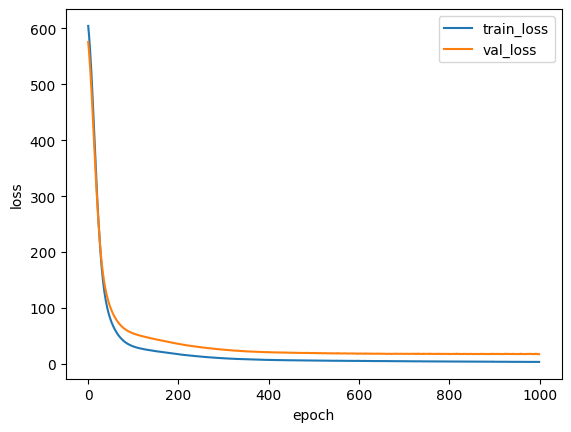

In [45]:
# 학습 결과 시각화
plt.plot(train_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

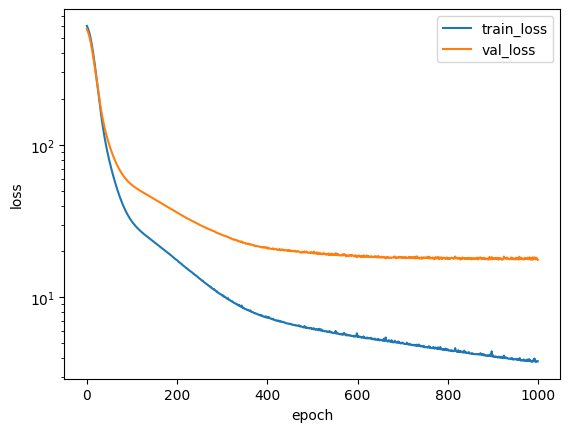

In [46]:
# 학습결과 시각화 로그스케일
plt.plot(train_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

# 모델 저장

## 모델 전체 저장 및 불러오기
- 모델구조, 파라미터 저장


In [61]:
# 모델 저장
# 모델 저장 경로
save_path = r'./models/{model_target}/'
# 모델 파일 이름
model_file_name = r'{model_name}{dict}_{YYMMDDhhmm}.pth'

#현 시간을 기준으로 파일 이름 생성
def get_timestamp(save_datetime=True):
    import datetime
    if save_datetime:
        return datetime.datetime.now().strftime('%Y%m%d%H%M')
    else:
        return ''
# 모델 저장 경로 생성
def get_path(model_name, model_target, save_datetime=True):
    file_name = model_file_name.format(model_name=model_name, dict=r'{dict}', YYMMDDhhmm=get_timestamp(save_datetime=save_datetime))
    return save_path.format(model_target=model_target) + file_name
# 모델 저장 함수
def save_model(model, model_name, model_target, save_dict=False, save_datetime=True):
    # 모델 저장 경로 생성
    os.makedirs(save_path.format(model_target=model_target), exist_ok=True)
    # 총 경로
    path = get_path(model_name, model_target)
    path = path.format(dict='_dict') if save_dict else path.format(dict='')
    if save_dict:
        # 모델의 state_dict 저장
        torch.save(model.state_dict(), path)
    else:
        # 모델 저장
        torch.save(model, path)
    
    print(f'{model_name} model saved in {path}')
    return path

In [62]:
# 모델 저장
path = save_model(boston_model, 'boston', 'boston')

boston model saved in ./models/boston/boston_202306080759.pth


In [63]:
path = r'./models/boston/boston_202306080759.pth'

In [64]:
# 모델 불러오기
load_boston_model = torch.load(path)

In [65]:
###################################
# 검증 단계
###################################
# GPU로 이동
load_boston_model = load_boston_model.to(DEVICE)
# 검증 모드로 변경
load_boston_model.eval()
# loss 계산을 위한 변수 초기화
val_loss = 0.0
# 역전파를 통한 gradient 계산 비활성화
with torch.no_grad():
    for X, y in boston_test_loader:
        # DEVICE로 이동
        X, y = X.to(DEVICE), y.to(DEVICE)
        # 1. 모델 추정
        y_pred = load_boston_model(X)    # forward propagation(순전파)
        # 2. loss 계산 및 누적
        val_loss += loss_func(y_pred, y).item()
# batch에 대한 loss 평균 계산
val_loss /= len(boston_test_loader)
######### epoch 검증 종료 #########
print(f'val_loss: {val_loss:.5f}')

val_loss: 17.62517


## state_dict 저장 및 로딩
- 모델 파라미터만 저장

In [66]:
# 모델 저장(모델의 state_dict 저장)
path = save_model(boston_model, 'boston', 'boston', save_dict=True)

boston model saved in ./models/boston/boston_dict_202306080759.pth


In [67]:
# 모델 불러오기
load_boston_model_2 = BostonModel()
load_boston_model_2.load_state_dict(torch.load(path))

<All keys matched successfully>

In [68]:
###################################
# 검증 단계
###################################
# GPU로 이동
load_boston_model_2 = load_boston_model_2.to(DEVICE)
# 검증 모드로 변경
load_boston_model_2.eval()
# loss 계산을 위한 변수 초기화
val_loss = 0.0
# 역전파를 통한 gradient 계산 비활성화
with torch.no_grad():
    for X, y in boston_test_loader:
        # DEVICE로 이동
        X, y = X.to(DEVICE), y.to(DEVICE)
        # 1. 모델 추정
        y_pred = load_boston_model_2(X)    # forward propagation(순전파)
        # 2. loss 계산 및 누적
        val_loss += loss_func(y_pred, y).item()
# batch에 대한 loss 평균 계산
val_loss /= len(boston_test_loader)
######### epoch 검증 종료 #########
print(f'val_loss: {val_loss:.5f}')

val_loss: 17.62517


# 분류 (Classification)

## Fashion MNIST Dataset - 다중분류(Multi-Class Classification) 문제

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋. 
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

이미지는 28x28 크기이며 Gray scale이다. *레이블*(label)은 0에서 9까지의 정수 배열이다. 아래 표는 이미지에 있는 의류의 **클래스**(class)들이다.

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

## 위스콘신 유방암 데이터셋 - 이진분류(Binary Classification) 문제

- **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, activation='sigmoid'
        - loss: binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
        
- 위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
- Feature
    - 종양에 대한 다양한 측정값들
- Target의 class
    - 0 - malignant(악성종양)
    - 1 - benign(양성종양)